## **Práctico 2**

Realizá un programa que integre numéricamente el problema de valor inicial para el modelo Integrate-and-Fire

$$
\tau_m \dot{V} = E_L - V + R_m I_e(t), 
$$

donde $E_L$ es el potencial en reposo, ·$I_e(t)$ es la intensidad de la corriente eléctrica que se inyecta (output), $R_m$ es la resistencia y $\tau_m$ es el tiempo que tarda el sistema en decaer $1/e$.

**a)** Reoslvé esta ecuación analíticamente, sin incorporar por ahora el umbral de disparo y manteniendo $I_e(t) = \mathrm{cte}$. Discutí e interpretá.

**b)** Usá el métoo de Runge-Kutta de cuarto orden para resolver el problema de valor inicial

$$
\tau_m \dot{V} = E_t - V + R_m I_e(t),  \quad V(t=0) = E_L,
$$

para $t_0 = 0$ y $t_f = 200\,\mathrm{ms}$, con paso $h = 0.05\,\mathrm{ms}$. Ahora debés gregar en la simulación el umbral de disparo propio del modelo Integrate-and-Fire. O sea, si $V(t)$ sobrepasa el valor $V_{\mathrm{th}}$, debés restituir el valor de $V(t)$ a $E_L$. Usá los siguientes valores

$$
V(0) = E_L = -65\,\mathrm{mV},\quad
R = 10\,\mathrm{M\Omega},\quad
V_{\mathrm{th}} = -50\,\mathrm{mV},\quad
\tau_m = 10\,\mathrm{ms}.
$$

La corriente externa $I_e(t)$ debe ser constante y tomar el valor $I_e = 2\,\mathrm{nA}$.

Presentá la solución con un gráfico del valor aproximado de $V(t)$ entre $0$ y $200\,\mathrm{ms}$ con los disparos y sin los disparos.

**c)** Ahora variá los valores de $I_e$ entre $0$ y $10\,\mathrm{nA}$ y calculá para cada valor la frecuencia de disparo. Graficá la frecuencia $\omega$ vs $I_e$. Intentá resolver esta ecuación analíticamente.

**d)** Repetí el punto b) pero ahora con una corriente aleatoria con distribución uniforme entre $0$ y $5\,\mathrm{nA}$ para cada actualización.



**a)**

Si la corriente externa es constante, la ecuación del modelo es una ecuación diferencial ordinaria homogénea de primer orden. Por lo tanto, la solución general es de la forma

$$
V(t) = B + C e^{-t/\tau_m},
$$

donde $B$ y $C$ son constantes. Reemplazando la solución en la ecuación, obtenemos

$$
\begin{align}
- \tau_m \dfrac{C}{\tau_m} e^{-t/\tau_m} &= E_L - B - C e^{-t/\tau_m} + R_m I_e \\
B &= E_L + R_m I_e.
\end{align}
$$

Además, considerando la condición inicial $V(0) = E_L$, tenemos

$$
\begin{align}
V_0 &= B + C \\
E_L &= E_L + R_m I_e + C \\
C &= - R_m I_e.
\end{align}
$$

Luego, la solución al sistema es

$$
V(t) = E_L + R_m I_e - R_m I_e e^{-t/\tau_m}.
$$

Es decir, la neurona comienza conun potencial de membrana igual al potencial de reposo $E_L$ y se despolariza paulatinamente hasta alcanzar el valor $V(t) \simeq E_L + R_m I_e$ para $t\gg \tau_m$.

**b)**

Integramos el sistema. 

In [1]:
## Importamos paquetes
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.integrate import solve_ivp

%matplotlib inline


## Parámetros para graficar
sns.set_style('darkgrid')
sns.set_context('talk')

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

BLUE = '#1f77b4'
ORANGE = '#ff7f0e'
GREEN = '#2ca02c'
PURPLE = '#9467bd'

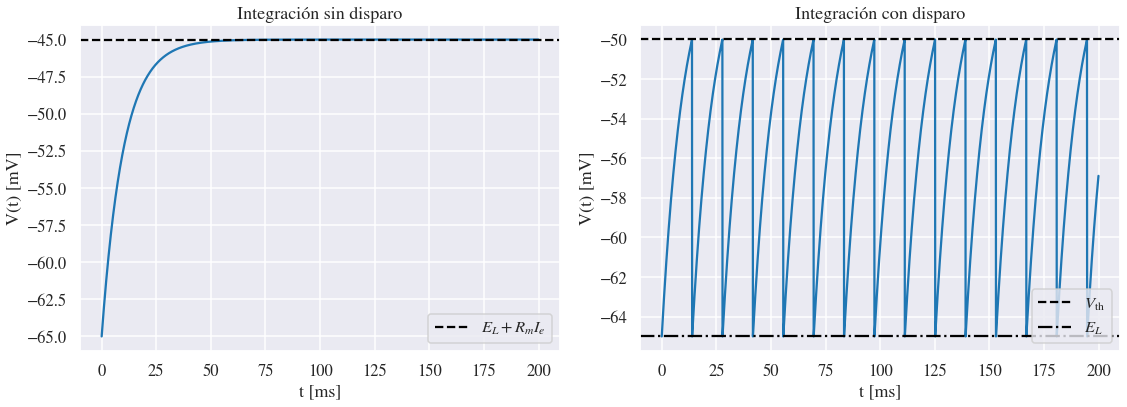

In [6]:
E_L = -65  ## Potencial de reposo
Rm  = 10   ## Resistencia de membrana
Ie  = 2    ## Corriente externa
Vth = -50  ## Voltaje de threshold
tau = 10   ## Tiempo característico

def integrate(t, y, *args):
    """
    Modelo neuronal de un compartimento
    con corriente externa constante
    """
    tau, E_L, Rm, Ie = args
    
    dydt = (1/tau)* (E_L - y + Rm*Ie)
    
    return dydt


def integrateAndFire(integrate_func, t0, tf, h, y0, Vth, *args):
    """
    Integra la función integrate_func(t, y, *args)
    entre t0 y tf con paso h y condicion inicial y0.
    Si y >= Vth, 
    """
    def fire(t, y, *args):
        return y[0] - Vth
    fire.terminal = True
    
    sols = []
    t_spikes = []
    t = t0
    y0 = (E_L,)
    while t < tf:
        t_span = (t0, tf)
        t_eval = np.arange(t0, tf, h)
        sol = solve_ivp(
            integrate_func, t_span=t_span, t_eval=t_eval, 
            y0=y0, max_step=h, args=args, 
            events=fire
        )
        sols.append(sol)
        t_events = sol.t_events[0]

        if t_events.size == 0:
            break

        t_spike = t_events[0]
        t_spikes.append(t_spike)
        t0 = t_spike + h

    t_values = np.concatenate([sol.t for sol in sols])
    y_values = np.concatenate([sol.y[0] for sol in sols])    
    return t_values, y_values, t_spikes


## Parámetros de integración
t0 = 0                        ## Tiempo inicial
tf = 200                      ## Tiempo final
h  = 0.05                     ## Paso de integración
t_span = (t0, tf)
t_eval = np.arange(t0, tf, h)

y0 = (E_L,)                   ## Condicion inicial
args = (tau, E_L, Rm, Ie)

sol_no_fire = solve_ivp(
    integrate, t_span=t_span, t_eval=t_eval, 
    y0=y0, max_step=h, args=args, 
)

t_values, y_values, t_spikes = integrateAndFire(
    integrate,
    t0, tf, h, y0, Vth, *args
)

## Graficamos las soluciones
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

ax = axes[0]
ax.set_title('Integración sin disparo')
ax.set_ylabel('V(t) [mV]')
ax.set_xlabel('t [ms]')
ax.plot(sol_no_fire.t, sol_no_fire.y[0])
ax.axhline(E_L + Rm*Ie, color='k', linestyle='--', label=r'$E_L + R_m I_e$')
ax.legend()

ax = axes[1]
ax.set_title('Integración con disparo')
ax.set_ylabel('V(t) [mV]')
ax.set_xlabel('t [ms]')
ax.plot(t_values, y_values)
ax.axhline(Vth, color='k', linestyle='--', label=r'$V_{\mathrm{th}}$')
ax.axhline(E_L, color='k', linestyle='-.', label=r'$E_L$')
ax.legend()

plt.tight_layout()
plt.show()

Podemos ver que, en el modelo sin disparos, el potencial de membrana se comporta según la predicción teórica. Es decir, aumenta progresivamente hasta saturar en el valor $E_L + R_m I_e$. En cambio, cuando se incorporan los disparos al modelo, al llegar al voltaje umbral el sistema se resetea, por lo que la solución presenta una serie de discontinuidades. Como el sistema es determinista, los disparos se encuentran equiespaciados.

**c)**

Para evaluar la frecuencia de disparos en función de la corriente de excitación, partimos de la solución

$$
V(t) = E_L + R_m I_e - R_m I_e e^{-t/\tau_m}.
$$

De acuerdo con la condición inicial $V(0) = E_L$, podemos considerar que tiempo $t=0$ se produjo un disparo. Sea $T$ el tiempo al cual se producirá el siguiente disparo. Entonces, el intervalo entre disparos es también igual a $T$, y la frecuencia de disparos es $\omega = 1/T$. De la ecuación anterior tenemos

$$
\begin{align}
V(T) &= E_L + R_m I_e - R_m I_e e^{-T/\tau_m} \\
V_{\mathrm{th}} &= E_L + R_m I_e - R_m I_e e^{-T/\tau_m} \\
e^{-T/\tau_m} &= \dfrac{E_L + R_m I_e - V_{\mathrm{th}} }{R_m I_e} \\
T &= \tau_m \ln\left( \dfrac{R_m I_e}{E_L + R_m I_e - V_{\mathrm{th}} } \right) \\
\omega &= \left[ \tau_m \ln\left( \dfrac{R_m I_e}{E_L + R_m I_e - V_{\mathrm{th}} } \right) \right]^{-1}.
\end{align}
$$

Esta expresión es sólo válida cuando el logaritmo es positivo, lo cual impone la condición $I_e > (V_{\mathrm{th}} - E_L)/R_m$. En particular, para los datos dados en este ejercicio, tenemos

$$
I_e > \dfrac{-50 + 65}{10} \,\mathrm{nA} = 1.5 \,\mathrm{nA}.
$$

Sujeto a la condición anterior y haciendo un desarrollo de Taylor del logaritmo, podemos ver que para corrientes suficientemente grandes se satisface

$$
\omega \simeq \dfrac{ E_L + R_m I_e - V_{\mathrm{th}} }{ \tau_m (V_{\mathrm{th}} - E_L) }.
$$

Es decir, la relación entre la corriente de excitación y la frecuencia de disparos es aproximadamente lineal.

In [17]:
Ie_values = np.arange(2, 10, 1, dtype='float')
firing_rates = np.zeros_like(Ie_values)
for j, Ie in enumerate(Ie_values):
    print(Ie)
    args = (tau, E_L, Rm, Ie)
    t_values, y_values, t_spikes = integrateAndFire(
        integrate,
        t0, tf, h, y0, Vth, *args
    )
    if len(t_spikes) > 0:
        isi = np.diff(t_spikes).mean()
        firing_rate = 1/isi
        firing_rates[j] = firing_rate
    else:
        firing_rates[j] = 0

2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0


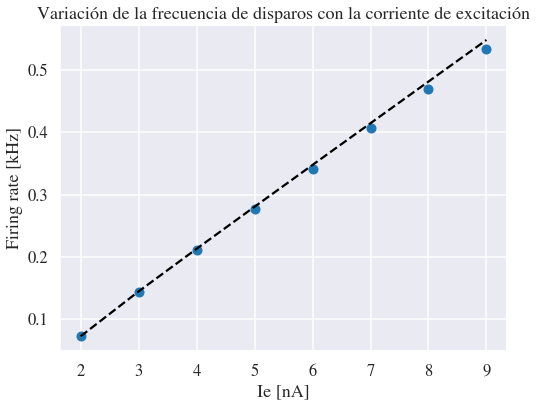

In [22]:
def theo_firing_rate(Ie, tau, Rm, E_L, Vreset, Vth):
    
    num = Rm*Ie + E_L - Vreset
    denom = Rm*Ie + E_L - Vth
    
    t_isi = tau*np.log(num/denom)
    r_isi = 1 / t_isi
    
    return r_isi

Vreset = E_L
theo_r_isi = theo_firing_rate(Ie_values, tau, Rm, E_L, Vreset, Vth)

ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

ax.set_title('Variación de la frecuencia de disparos con la corriente de excitación')
ax.set_ylabel('Firing rate [kHz]')
ax.set_xlabel('Ie [nA]')
ax.plot(Ie_values, firing_rates, 'o')
ax.plot(Ie_values, theo_r_isi, color='k', linestyle='--')
plt.show()

**d)**

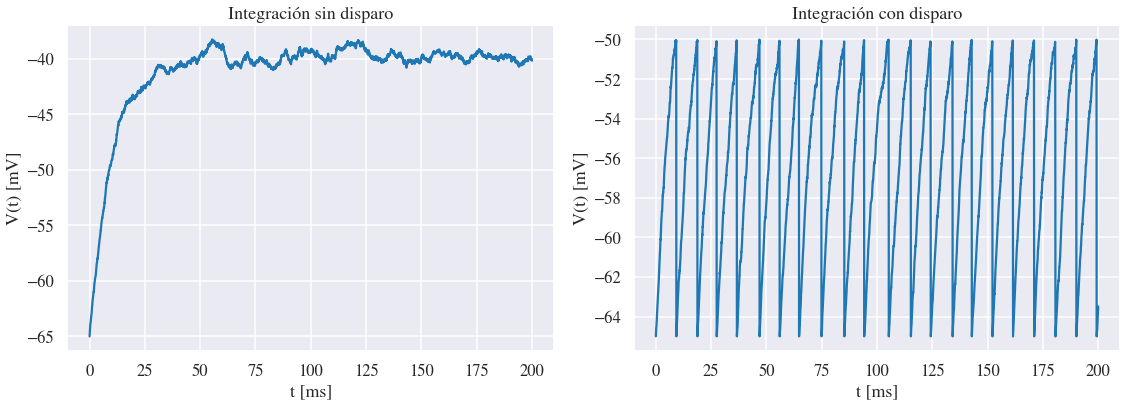

In [20]:
min_Ie = 0
max_Ie = 5
avg_Ie = (max_Ie - min_Ie) / 2

def integrate_rand_Ie(t, y, *args):
    """
    Modelo neuronal de un compartimento
    con corriente externa aleatoria
    """
    tau, E_L, Rm = args
    
    Ie = (max_Ie - min_Ie)*np.random.random()
    
    dydt = (1/tau)* (E_L - y + Rm*Ie)
    
    return dydt

y0 = (E_L,)                   ## Condicion inicial
args = (tau, E_L, Rm)

sol_no_fire = solve_ivp(
    integrate_rand_Ie, t_span=t_span, t_eval=t_eval, 
    y0=y0, max_step=h, args=args, 
)

t_values, y_values, t_spikes = integrateAndFire(
    integrate_rand_Ie,
    t0, tf, h, y0, Vth, *args
)

## Graficamos las soluciones
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

ax = axes[0]
ax.set_title('Integración sin disparo')
ax.set_ylabel('V(t) [mV]')
ax.set_xlabel('t [ms]')
ax.plot(sol_no_fire.t, sol_no_fire.y[0])

ax = axes[1]
ax.set_title('Integración con disparo')
ax.set_ylabel('V(t) [mV]')
ax.set_xlabel('t [ms]')
ax.plot(t_values, y_values)

plt.tight_layout()
plt.show()

Agreamos, al gráfico anterior de $\omega$ vs $I_e$, la frecuencia calculada para el caso con excitación estocástica. En promedio, la corriente inyectada es de $2.5\,\mathrm{nA}$, por lo que es esperable que la frecuencia sea similar a la obtenida con esa misma corriente constante.

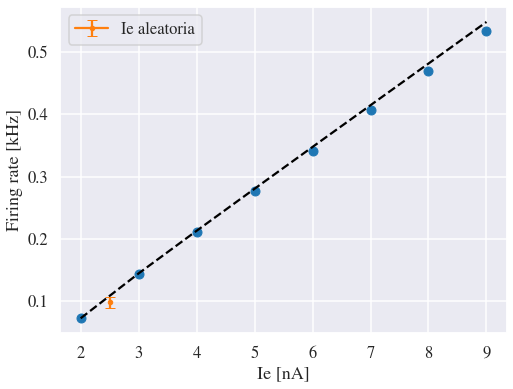

In [23]:
def calcular_periodo(x, h=1):
    """
    Calcula el período de una señal oscilante como el promedio
    entre dos tiempos consecutivos en los cuales la señal pasa 
    de tener un valor por debajo de la media a un valor por 
    encima de la media.
    """
    x = np.array(x)
    x = x - x.mean()
    
    ## Cantiddad de pasos entre valores positivos
    pasos_entre_pos = np.diff(np.where(x>0)[0])
    
    distancias = np.diff(np.where(pasos_entre_pos>1)[0][::2]) * h
    per = distancias.mean()
    per_std = distancias.std()
    
    return per, per_std

per, per_std = calcular_periodo(y_values, h=h)
r_isi = 1/per
r_isi_std = r_isi*per_std/per

ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

ax.set_ylabel('Firing rate [kHz]')
ax.set_xlabel('Ie [nA]')
ax.plot(Ie_values, firing_rates, 'o')
ax.plot(Ie_values, theo_r_isi, color='k', linestyle='--')
ax.errorbar(
    avg_Ie, r_isi, r_isi_std, marker='.', capsize=5, label='Ie aleatoria', zorder=10
)
ax.legend()

plt.show()

Podemos ver que efectivamente, la frecuencia obtenida se asemeja al caso de corriente constante. 